In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skewnorm, norm

from utils import skew_to_alpha, moments
from sharpe_ratio_stats import estimated_sharpe_ratio, ann_estimated_sharpe_ratio, estimated_sharpe_ratio_stdev, probabilistic_sharpe_ratio

In [32]:
np.random.seed(0)

## Strategy 1 - *Simulate a distribution of returns with negative skewness*

In [33]:
MEAN_RETURNS = 0.01
STD_RETURNS  = 0.01
SKEW_RETURNS = -0.99  # must be between [-0.99, 0.99]

alpha = skew_to_alpha(SKEW_RETURNS)

dist_st1 = skewnorm(loc=MEAN_RETURNS, scale=STD_RETURNS, a=alpha)

# NOTE: scipy.skewnorm can not mantain the mean and std of the distribution while changing the skewness
true_mean = dist_st1.stats('m').item()
true_std  = np.sqrt(dist_st1.stats('v').item())

Generates random returns and check their moments statistic 
(in a large sample the *skew* should be equal to `skew_returns`, **the other moments are not guaranteed to acommplish our initial conditions**)

In [34]:
SIZE = 50

In [35]:
SEED_ST1 = 44  # 5 39  44(13479)

returns_st1 = dist_st1.rvs(size=SIZE, random_state=SEED_ST1)

moments_st1 = moments(returns_st1)
print(moments_st1)

mean    0.001524
std     0.006305
skew   -1.139566
kurt    4.635861
dtype: float64


Calculate their estimated Sharpe ratio (SR^). *It is "estimated" because it use the historical returns as a prediction of the future returns.*

In [7]:
sr_st1 = estimated_sharpe_ratio(returns_st1)
print('SR st1 dist.:', sr_st1)

SR st1 dist.: 0.24171729852769175


In [8]:
sr_ann_st1 = ann_estimated_sharpe_ratio(returns_st1)
print('SR Annual. st1 dist.:', round(sr_ann_st1, 2))

SR Annual. st1 dist.: 3.91


## Strategy 2 - *Simulate a normal distribution of returns with better `mean` and same `std` as the strategy 1*

By definition the SR, in a big data sample, of this strategy (this returns distribution) must be greater than the SR of Strategy 1...but with a few data?

In [9]:
EXTRA_EDGE = 0.0015

dist_st2 = norm(loc=true_mean+EXTRA_EDGE, scale=true_std)

Generates random returns and check their moments statistic (in a large sample the *mean* and *std* should be equal to the `moments_st1`, and the *skew* should be 0 and *kurtosis* 3)

In [10]:
SEED_ST2 = 34430  # 1003 4223 4968 8039 11304(44)30481  34430

returns_st2 = dist_st2.rvs(size=SIZE, random_state=SEED_ST2)

moments_st2 = moments(returns_st2)
print(moments_st2)

mean    0.001316
std     0.005692
skew    0.569893
kurt    2.895561
dtype: float64


In [17]:
sr_st2 = estimated_sharpe_ratio(returns_st2)
print('SR st2 dist.:', sr_st2)

SR st2 dist.: 0.23128484671726954


In [18]:
sr_ann_st2 = ann_estimated_sharpe_ratio(returns_st2)
print('SR Annual. st2 dist.:', round(sr_ann_st2, 2))

SR Annual. st2 dist.: 3.74


> Ooops, it seems that the Strategy 2 is worst than the Strategy 1... sure?

## Probabilistic Sharep Ratio (PSR)

At this point, imagine that you want to invest your money in one of these two differenet investing strategies, so ***which one will you choose?***

**Probably you will choose the first one**, because have an annualized sharpe ratio of 3.91 and the second strategy 3.74.

### But, is this a good decision?

Let's see how much confidence we can have with each SR estimated. We will calculate the probability that the TRUE SR, SR*, (not the estimated SR^) is above 0, so how confidence can we be that there is TRU skill/alpha behind each strategy.

In [13]:
SR_BENCHMARK = 0  # SR*

In [19]:
psr_st1 = probabilistic_sharpe_ratio(returns_st1, sr_benchmark=SR_BENCHMARK)
print('PSR st1:', psr_st1)

PSR st1: 0.9289428169745353


In [20]:
psr_st2 = probabilistic_sharpe_ratio(returns_st2, sr_benchmark=SR_BENCHMARK)
print('PSR st2:', psr_st2)

PSR st2: 0.9566184677994527


> As you can see the Probabilistic Sharpe Ratio (PSR) says that despite of the lower SR^ of the second strategy, this strategy 2 have more chances that in the future its returns will have a TRUE SR greater than 0.  
**We can say with a 95.66% confidence that the strategy 2 it's a winner strategy, but we "only" have a certainty of 92.89% that the strategy 1 can generate *alpha* too.**

Plotting the returns distribution, we can confirm that strategy 1 returns have a big negative skewness, and this makes bigger the stdDev of its SR^ estimates, so we have less certainty on our estimation (lower PSR).

Text(0.5, 1.0, 'Strategy 1 returns distribution')

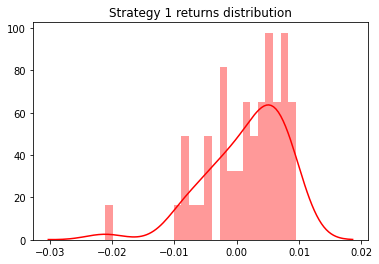

In [21]:
sns.distplot(pd.Series(returns_st1), hist=True, kde=True, color='red',  bins=SIZE//2).set_title('Strategy 1 returns distribution')

Text(0.5, 1.0, 'Strategy 2 returns distribution')

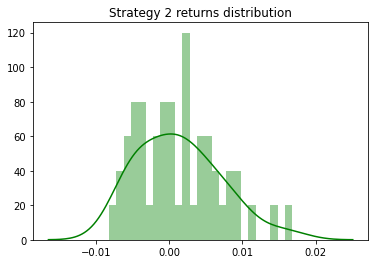

In [22]:
sns.distplot(pd.Series(returns_st2), hist=True, kde=True, color='green',  bins=SIZE//2).set_title('Strategy 2 returns distribution')

In [23]:
estimated_sr_std_st1 = estimated_sharpe_ratio_stdev(returns_st1)
estimated_sr_std_st2 = estimated_sharpe_ratio_stdev(returns_st2)

print('The estimated SR^ of strategy 1 have a stdDev of: ', estimated_sr_std_st1)
print('The estimated SR^ of strategy 2 have a stdDev of: ', estimated_sr_std_st2)

The estimated SR^ of strategy 1 have a stdDev of:  0.1646617486727741
The estimated SR^ of strategy 2 have a stdDev of:  0.1350390685081054


## Out-of-sample checks

**Now we will check if our decision of investing in strategy 2 instead of investing in the strategy 1 (that had a better SR), was a good or bad decision.**

For that we will generate extra, and bigger, samples of each distribution and chechk wich strategy have a better SR.
> Incresing the number of returns/samples for calcualting the SR^ makes the stdDev of this estimation drop drastically.

In [24]:
OOS_SIZE = 10000000

In [25]:
oos_returns_st1 = dist_st1.rvs(size=OOS_SIZE)

true_moments_st1 = moments(oos_returns_st1)
print(true_moments_st1)

mean    0.002028
std     0.006033
skew   -0.989043
kurt    3.857675
dtype: float64


In [26]:
true_sr_ann_st1 = ann_estimated_sharpe_ratio(oos_returns_st1)
print('TRUE SR Annual. Strategy 1:', round(true_sr_ann_st1, 2))

TRUE SR Annual. Strategy 1: 5.44


In [27]:
oos_returns_st2 = dist_st2.rvs(size=OOS_SIZE)

true_moments_st2 = moments(oos_returns_st2)
print(true_moments_st2)

mean    0.003524
std     0.006033
skew    0.000689
kurt    2.998471
dtype: float64


In [28]:
true_sr_ann_st2 = ann_estimated_sharpe_ratio(oos_returns_st2)
print('TRUE SR Annual. Strategy 2:', round(true_sr_ann_st2, 2))

TRUE SR Annual. Strategy 2: 9.46


## Conclusions
#### We can see that in the long term the Strategy 2 is much better than the Strategy 1. Its TRUE SR is around 9.46 and the TRUE SR of Strategy 1 is around 5.43. 
#### This is due to the `EXTRA_EDGE` we added tothe returns distributions of the Strategy 2. 
#### So, despite of the lower SR^ in the small sample, we were able to choose the best Strategy using the Probabilistic Sharpe Ratio (PSR). 
In 3 years our money will have grown x3 times more (aprox.) than if we had invested in the Strategy 1!

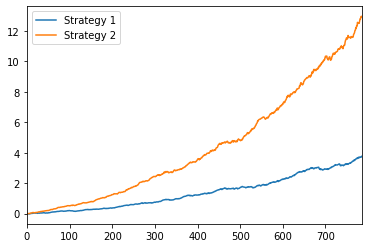

In [29]:
pd.DataFrame({'Strategy 1': pd.Series(oos_returns_st1).add(1).cumprod().sub(1).iloc[:262*3],
              'Strategy 2': pd.Series(oos_returns_st2).add(1).cumprod().sub(1).iloc[:262*3]}).plot()

NOTE: In this notebook we have checked the impact of the skewness in the SR^ but the kurtosis also have an impact on the SR^ and its estimated error. But there is no way for generating random returns with a predefined kurtosis.
> Let me know in a issue if you now one way to generate random returns with a desired kurtosis, or with a skewness greater than [-0.99, 0.99].

In [36]:
returns_st1

array([ 0.00211889, -0.00263655, -0.00243586, -0.00607123, -0.00449968,
       -0.00724753, -0.00817656,  0.00911775,  0.0094774 ,  0.00421977,
       -0.00019997,  0.00819127, -0.00202789,  0.00387823,  0.00032343,
        0.00574112, -0.00055158,  0.00905063,  0.00221801, -0.0023687 ,
       -0.00179685,  0.00754297,  0.00821062, -0.00430742,  0.00542186,
       -0.00139933,  0.00332385,  0.00951114,  0.00645392,  0.00754644,
        0.00664946,  0.00380115,  0.0052146 ,  0.00176448,  0.00506014,
        0.00773454,  0.00488271, -0.02115876,  0.00624238,  0.00217167,
        0.00353067, -0.00779996,  0.00168676, -0.00870683,  0.00579779,
        0.00754729,  0.00589649,  0.00167121, -0.0100708 , -0.00433792])

In [39]:
# pd.Series.to_csv()
pd.Series(returns_st1).to_csv('returns_st1.csv', index=False)

/home/rbriones/Documents/misEnvironments/dao/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [44]:
ret= pd.read_csv('returns_st1.csv', header=None, squeeze=True)

In [45]:
import quantstats as qs

In [46]:
qs.stats.sharpe(ret, annualize=False)

0.24171729852769172

In [47]:
estimated_sharpe_ratio(ret)

0.24171729852769172